In [1]:
from u_net import *
import sys
import random
import warnings
import pandas as pd
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import tensorflow.keras.backend as K

2.0.0-dev20190318


In [2]:
#from tf.keras import backend as K
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'input/stage1_train/'
TEST_PATH = 'input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
random.seed = 40
np.random.seed = 40

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:26<00:00,  6.17it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 93.98it/s]

Done!


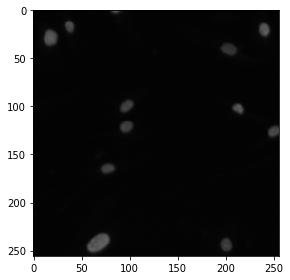

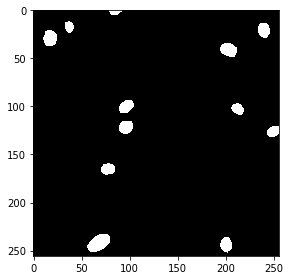

In [5]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [6]:
#eval metrics
# def mean_iou(y_true, y_pred):
#     return tf.metrics.mean_iou(
#     y_true,
#     y_pred,
#     num_classes,
#     weights=None,
#     metrics_collections=None,
#     updates_collections=None,
#     name=None
#     )
    

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.cast(y_pred > t, dtype=tf.int32)
        score, up_opt = tf.metrics.MeanIoU(y_true, y_pred_, 2)
        tf.compat.v1.get_session_handle().run(tf.compat.v1.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
input_dimension=(256,256,3)
lr=0.001

inputs = Input(input_dimension)
inblock_inp= inblock(inputs)
resblock_a1=resblock_A(inblock_inp,32)
path1=Path_1(resblock_a1)
    
    #reduction_a=reduction_A(resblock_a1)
reduction_a=tf.keras.layers.MaxPooling2D((2,2))(resblock_a1)
resblock_a2=resblock_A(reduction_a,64)
path2=Path_2(resblock_a2)
    
reduction_b=tf.keras.layers.MaxPooling2D((2,2))(resblock_a2
                                                         )
resblock_b1=resblock_B(reduction_b)
path3=Path_3(resblock_b1)
    
Mpooling=tf.keras.layers.MaxPooling2D((2,2))(resblock_b1)
resblock_b2=resblock_B(Mpooling)
path4=Path_4(resblock_b2)
    
Mpooling2=tf.keras.layers.MaxPooling2D((2,2))(resblock_b2)
resblock_c=resblock_C(Mpooling2)
    
Up1=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(resblock_c),path4],axis=3)
resblock_b2=resblock_B(Up1)

Up2=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(resblock_b2),path3],axis=3)
resblock_b3=resblock_B(Up2)

    
Up3=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(resblock_b3),path2],axis=3)
resblock_a3=resblock_A(Up3,64)
    
    
    
Up4=tf.keras.layers.concatenate([tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(resblock_a3),path1],axis=3)
resblock_a4=resblock_A(Up4,32)
outblock=inblock(resblock_a4)
    
conv_final=conv_2d(outblock,1,1,1,activation='sigmoid')
print(conv_final.shape)    
    
model = tf.keras.Model(inputs=[inputs], outputs=[conv_final])
#model.compile(tf.optimizers.Adam(lr),loss = 'binary_crossentropy', metrics = ['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
print(model.summary())


Tensor("input_1:0", shape=(None, 256, 256, 3), dtype=float32)
inblock (None, 256, 256, 12)
resblock_a (None, 256, 256, 48)
path (None, 256, 256, 48)
resblock_a (None, 128, 128, 192)
path2 (None, 128, 128, 384)
resblock_B (None, 64, 64, 576)
path3 (None, 64, 64, 1152)
resblock_B (None, 32, 32, 1728)
path4 (None, 32, 32, 32)
resblock_c (None, 16, 16, 5184)
resblock_B (None, 32, 32, 864)
resblock_B (None, 64, 64, 4224)
resblock_a (None, 128, 128, 1792)
resblock_a (None, 256, 256, 320)
Tensor("batch_normalization_94/cond/Identity:0", shape=(None, 256, 256, 320), dtype=float32)
inblock (None, 256, 256, 1280)
(None, 256, 256, 1280)


TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use TensorFlow ops such as tf.cond to execute subgraphs conditioned on the value of a tensor.

In [9]:
# Fit model
#model.compile(tf.optimizers.Adam(learning_rate=0.001),loss = 'binary_crossentropy', metrics = ['accuracy'])
earlystopper = tf.keras.callbacks.EarlyStopping(patience=5, verbose=1)
checkpointer = tf.keras.callbacks.ModelCheckpoint('test_1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=50,shuffle=True)

ValueError: A target array with shape (670, 256, 256, 1) was passed for an output of shape (None, 256, 256, 1280) while using as loss `binary_crossentropy`. This loss expects targets to have the same shape as the output.

In [ ]:
# Predict on train, val and test
model = load_model('test_1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()